<a href="https://colab.research.google.com/github/harrisb002/CS_479/blob/Labs/histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image histogram

We have already seen how the distribution of pixel intensities can be measured in the form of a histogram. It gave us a quick estimate of the intensities present in an image and to check for problems like saturation.

Now let us see how we can use "point operation" (transforming one gray level to another) to pre-process images. For example, to improve image contrast, or for equalizing the histogram (i.e. making the histogram more uniform).

In [1]:
import skimage, os
from skimage import data, exposure, img_as_float, io
import skimage.exposure as ex
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

uint8 (303, 384)


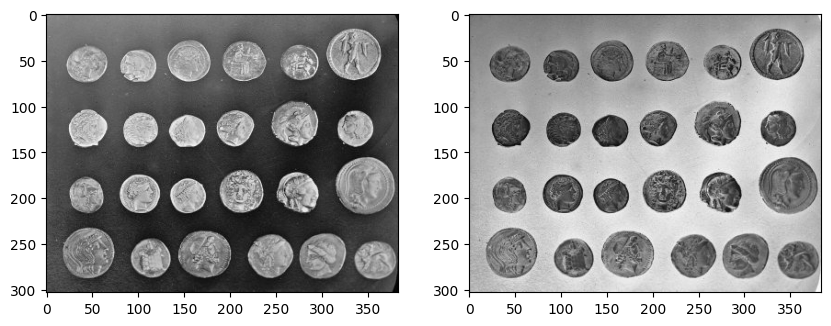

In [2]:
img = data.coins()

#This is a grayscale uint8 image with  values from 0-255
print(img.dtype, img.shape)

#Invert the image by subtracting from 255
img_c = 255 - img

#Display both images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img_c, cmap = 'gray');


Essentially we have applied a transformation that takes

grayscale 0 --> 255

grayscale 1 --> 254

grayscale 2 --> 253

.

.

.

grayscale 255 --> 0

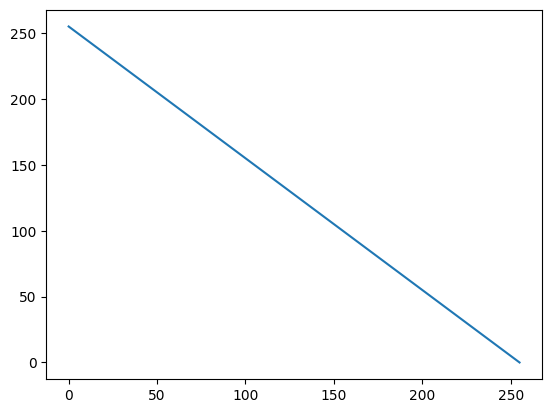

In [3]:
#Create a simple transformation function that maps 0->255, 1->254, and so on...
a = np.array([0, 255])
b = np.array([255, 0])
lin = np.interp(range(256),a,b)
plt.plot(lin)
plt.show()

[]


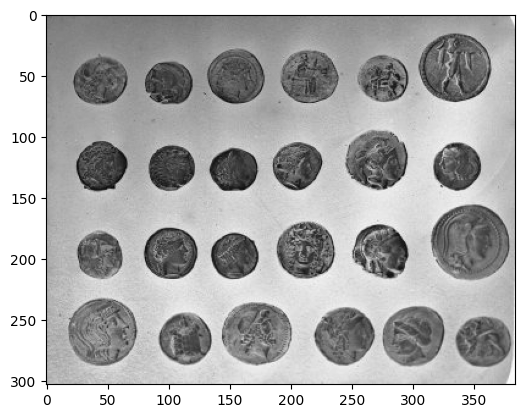

In [4]:
#Apply the transformation lin to the grayimage img
img_t = lin[img]
plt.imshow(img_t, cmap = 'gray') # The resulting image is called the Complement of the image

#This should be identical to the image img_c (it is the same transformation!)
a = np.flatnonzero(img_c - img_t)
print(a)

The `interp` function makes it easier to create such transformation mapping without explicitly providing all the data points. Another example that doubles the pixel values is provided below.

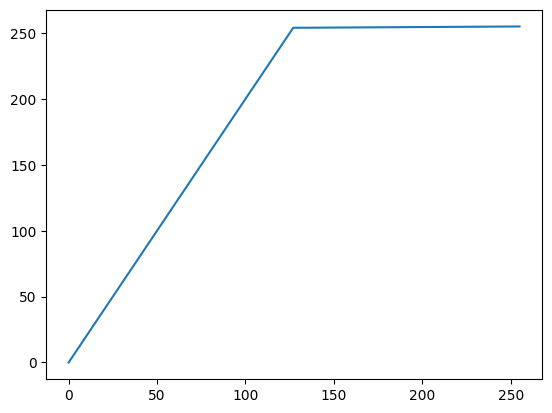

In [5]:
#Create a transformation function that maps 0->0, 1->2, 2->4, 127->254, and all pixels greater than 127 mapped to 255
a = np.array([0, 127, 255])
b = np.array([0, 254, 255])
lin2 = np.interp(range(256),a,b)
plt.plot(lin2)
plt.show()

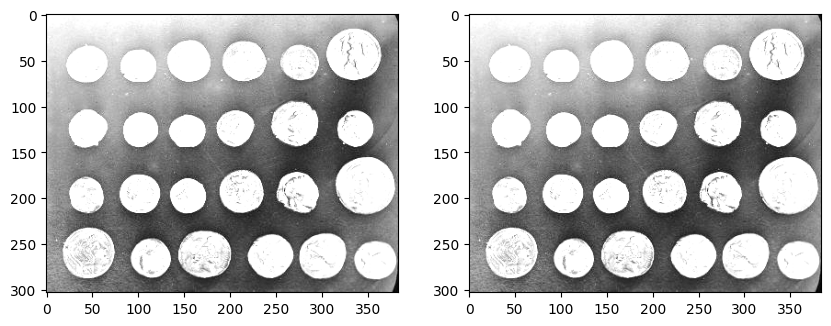

In [6]:
#Apply the transformation lin2 to the grayimage img
img_t = lin2[img]

#Display both images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(img_t, cmap = 'gray')
ax[1].imshow(2*img_as_float(img_t), cmap = 'gray');

## Part A (10 points)
Interesting special effects can be obtained by complementing only part of the image; for
example by taking the complement of pixels of gray value 128 or less, and leaving other pixels untouched.

![Transformation showing part complement|20%](part_complement.png)

Sample output when applied to the coins image and the coffee image.
![Transformation showing part complement for coins|20%](part_complement_coins.png)
![Transformation showing part complement for coffee|20%](part_complement_coffee.png)


In [7]:
def partComplement(img):

    '''
    Complements all pixels of gray value 128 or less, and leaves others untouched
    Returns the transformation and the transformed image in a tuple
    '''
    # YOUR CODE HERE
    a = np.array([0,128,129,255])
    b = np.array([255,127,129,255])
    lin = np.interp(range(256),a,b)

    plt.plot(lin)
    plt.show

    #Apply the transformation lin to the grayimage
    img_t = lin[img]

    print(sum(lin))

    return lin, img_t

49023.0
127.0 254.0 (303, 384) float64
All tests passed


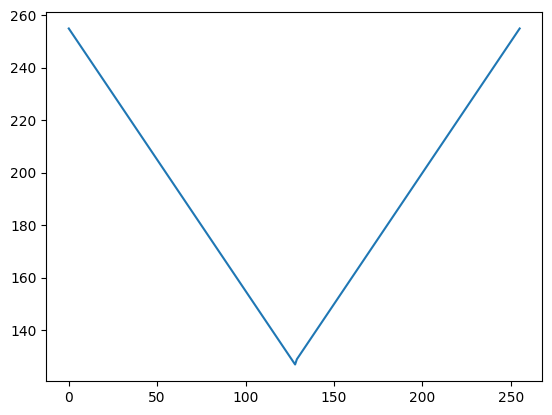

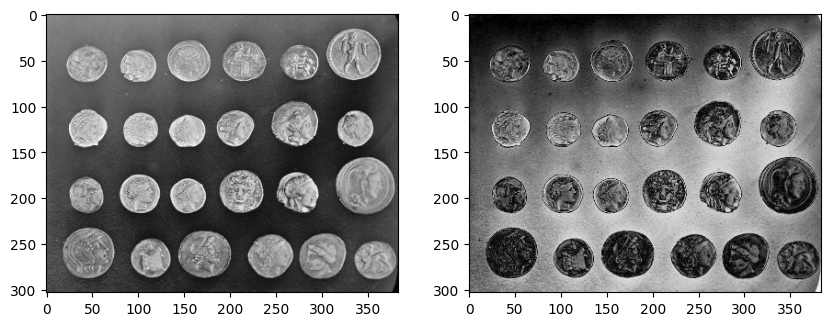

In [8]:
img = data.coins()
lin, img_t = partComplement(img)
print(img_t.min(), img_t.max(), img_t.shape, img_t.dtype)

#Display both images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img_t, cmap = 'gray');

assert(sum(lin) == 49023)
assert(math.isclose(np.mean(img_t), 180.983928))
print("All tests passed")

0 255 (400, 600, 3) uint8
49023.0
127.0 255.0 (400, 600, 3) float64
All tests passed


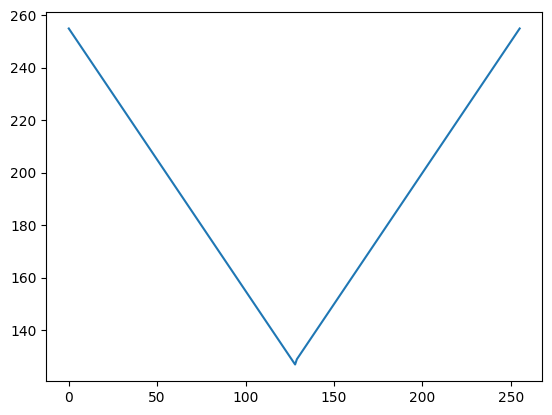

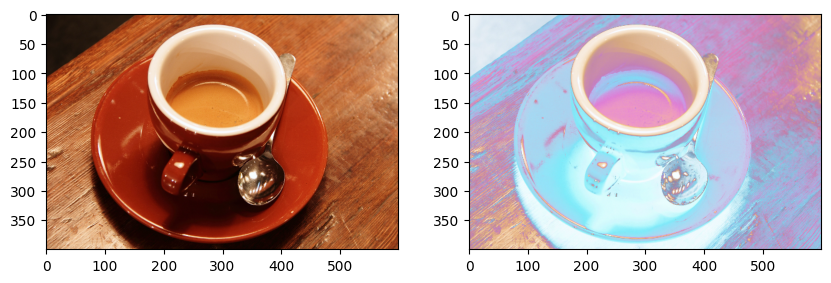

In [9]:
#load a color image
img = data.coffee()
print(img.min(), img.max(), img.shape, img.dtype)

#transformation will work seamlessly
lin, img_t = partComplement(img) #img.astype(np.uint32)
print(img_t.min(), img_t.max(), img_t.shape, img_t.dtype)


#Display both images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(img, cmap = 'gray')
#Since output of transformation is of type float64, we must manually rescale to visualize the result
ax[1].imshow(img_t/255, cmap = 'gray');

assert(math.isclose(np.mean(img_t), 198.1540236))
print("All tests passed")

Using the same idea we can perform piecewise linear stretching.

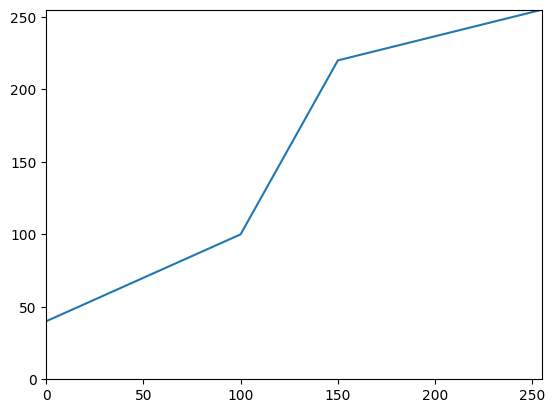

In [10]:
#applying interpolation
a = np.array([0, 100, 150, 255])
b = np.array([40, 100, 220, 255])
lin = np.interp(range(256),a,b)
len(lin)
plt.plot(lin)
plt.axis([0, 255, 0, 255])
plt.show()

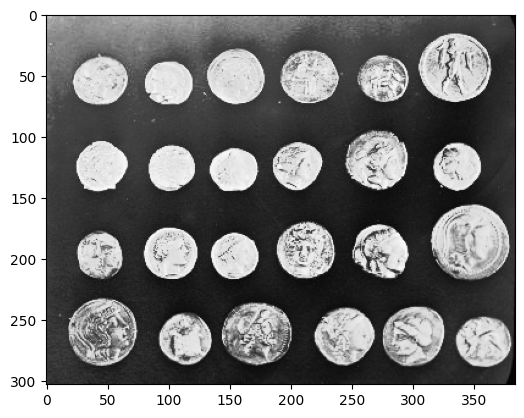

In [11]:
img = data.coins()
img_pwl = lin[img] #applying the piecewise linear transformation lin to the grayimage img
plt.imshow(img_pwl, cmap = 'gray')

This idea (of piece wise linear transformation) can be used to transform the histogram of an image such that it improves the "contrast". This is called Contrast Stretching. Essentially, the idea is to find the gray values with high frequency and map them to a larger range, thereby "stretching" the gray value range that has non-zero frequency.

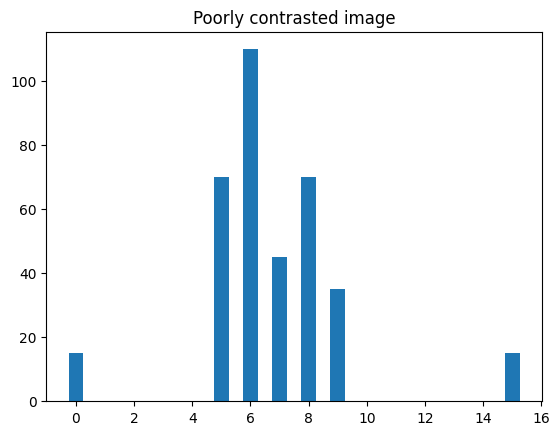

In [12]:
#Consider a toy data with following frequencies
freq = np.array([15, 0, 0, 0, 0, 70, 110, 45, 70, 35, 0, 0, 0, 0, 0, 15])
plt.bar(np.arange(16), freq, 0.5)
plt.title("Poorly contrasted image")
plt.show()

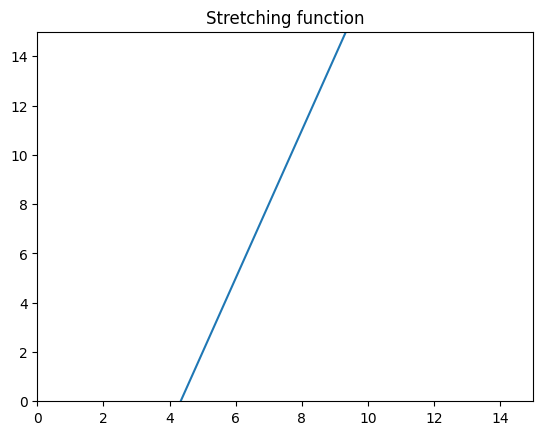

In [13]:
#Mapping that takes gray levels 5 - 9 (x-axis) to 2 - 14 (y-axis)
#thereby, stretching the range of gray values that occur in the image
a = np.array(range(16))
b = 3*(a-5) + 2

# Gray values outside the 5-9 range are transformed according to the linear function at the ends of the above transformation
plt.axis([0, 15, 0, 15])
plt.plot(b)
plt.title("Stretching function")
plt.show()

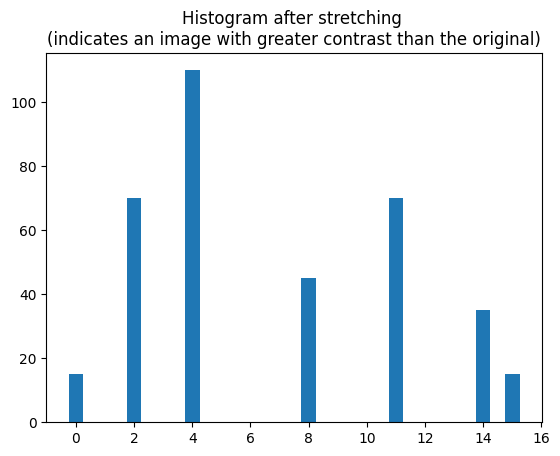

In [14]:
newfreq = np.array([15, 0, 70, 0, 110, 0, 0, 0, 45, 0, 0, 70, 0, 0, 35, 15])
plt.bar(np.arange(16), newfreq, 0.5)
plt.title("Histogram after stretching \n(indicates an image with greater contrast than the original)")
plt.show()

The trouble with the above method of histogram stretching is that they require
user input. Sometimes a better approach is provided by **histogram equalization**, which is an entirely automatic procedure. The idea is to change the histogram to one that is uniform so that every bar on the histogram is of the same height, or in other words each gray level in the image occurs with the same frequency.

array([  216.,  8219., 18297., 14483., 12247., 11255.,  8066.,  8536.,
        7524.,  7050.,  7775.,  6457.,  3687.,  1738.,   725.,    77.])

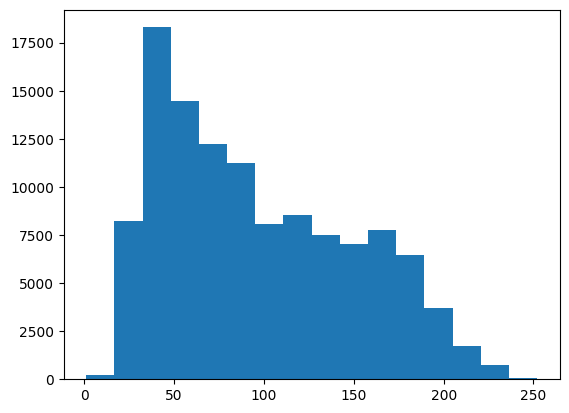

In [15]:
img = data.coins()
#display histogram of the image using 16 bons
n, bins, _ = plt.hist(img.ravel(), bins=16)
n

In [16]:
#FYI: Histogram can also be computed via the exposure module (which is imported as ex here)

#convert img to float (bins value is ignored for integer arrays)
histn, bins2 = ex.histogram(img_as_float(img), nbins= 16)
#Check, the histogram is identical to that obtained above. However, it does not display anything.


In [17]:
help(ex.equalize_hist)

Help on function equalize_hist in module skimage.exposure.exposure:

equalize_hist(image, nbins=256, mask=None)
    Return image after histogram equalization.
    
    Parameters
    ----------
    image : array
        Image array.
    nbins : int, optional
        Number of bins for image histogram. Note: this argument is
        ignored for integer images, for which each integer is its own
        bin.
    mask : ndarray of bools or 0s and 1s, optional
        Array of same shape as `image`. Only points at which mask == True
        are used for the equalization, which is applied to the whole image.
    
    Returns
    -------
    out : float array
        Image array after histogram equalization.
    
    Notes
    -----
    This function is adapted from [1]_ with the author's permission.
    
    References
    ----------
    .. [1] http://www.janeriksolem.net/histogram-equalization-with-python-and.html
    .. [2] https://en.wikipedia.org/wiki/Histogram_equalization



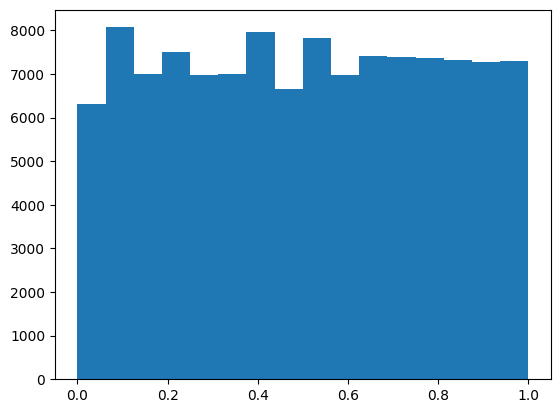

In [18]:
#Python supplies the equalize_hist method in the exposure module to perform histogram equalization:
ch = ex.equalize_hist(img) #default number of bins = 256
n, bins, _ = plt.hist(ch.flatten(), bins=16)


Notice the range of x-axis in the histograms of the original image and equalized image. What causes them to be different? What change can you do to make them have the same range?

Let us write a helper function to display original image, equalized image and their respective histograms.

In [19]:
def plotImgAndHist(img, ch, bins=256):
    #plot the equalized image next to original image
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    #display original and equalized image
    ax[0, 0].imshow(img, cmap = 'gray')
    ax[0, 0].set_title('Low contrast image')
    ax[0, 1].imshow(ch, cmap = 'gray')
    ax[0, 1].set_title('Histogram equalization')

    #display histograms of the image with the desired number of bins
    h1 = ax[1, 0].hist(img.ravel(), bins)
    h2 = ax[1, 1].hist(ch.flatten(), bins)



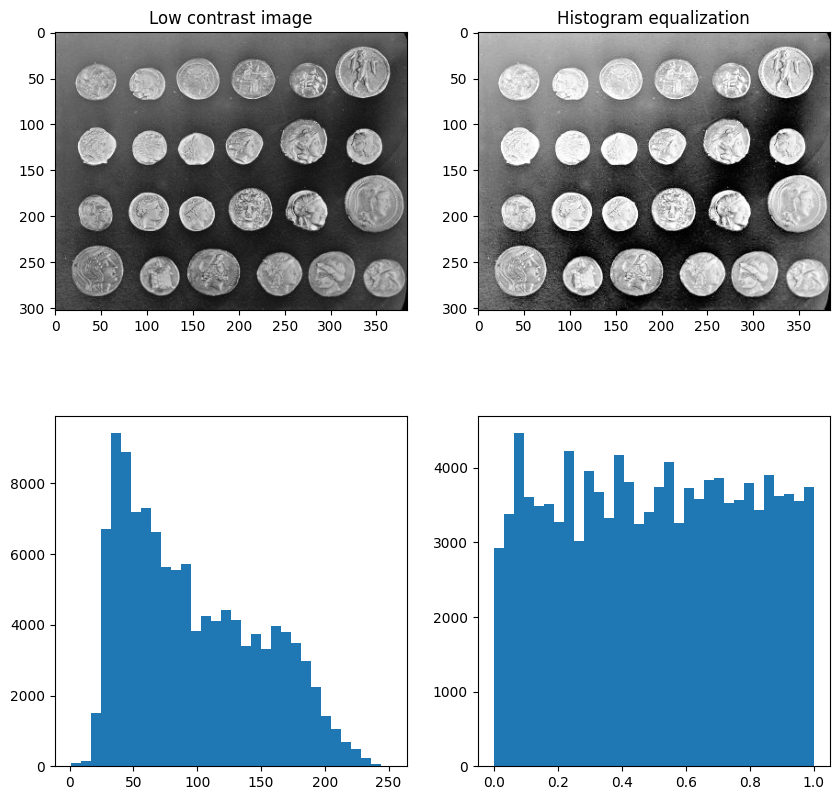

In [20]:
plotImgAndHist(img, ch, 32)

## Part B (10 points)
We have seen the affect of histogram equalization on the image. Without going into details of how it works at this moment, we notice that essentially it involves a graylevel transformation that attempts to "spread out the most frequent intensity values". The transformation acts on the gray levels regardless of the location of pixels. So, for example, a gray value 28 gets mapped to 82 regardless of whether the pixel (with value 28) occurs in the center of the image or on the corner. This "global mapping" can sometimes lead to unnatural looking images.


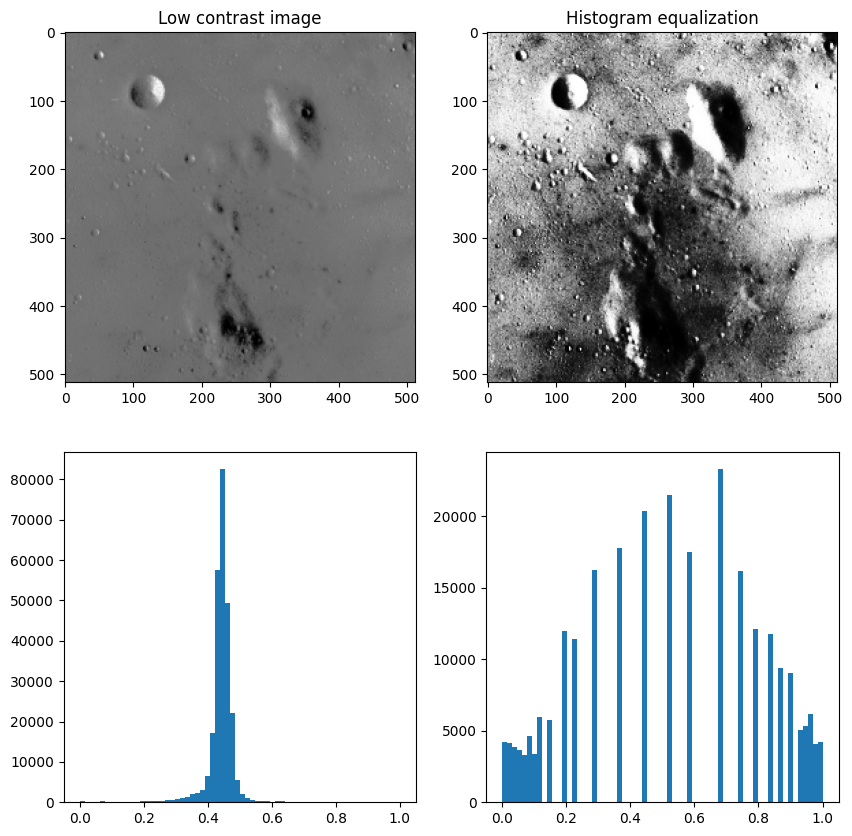

In [21]:
img = img_as_float(data.moon())
ch = ex.equalize_hist(img, 256) #providing 256 as the parameter to the equalize_hist function
plotImgAndHist(img, ch, 64)

[link text](https://)Instead of equalizing the entire image, we can equalize each quarter of the image separately and then combine all the quarters.

In [22]:
def equalizeQuarters(img, bins=256):
    '''
    Divides the image into 4 quarters,
    Equalizes each quarter by using the provided bins as parameter to equalize_hist,
    Combines the equalized quarters into a single image and returns it.

    '''
    #assume gray level images
    assert(len(img.shape) == 2)

    # YOUR CODE HERE

    # Get the height and width of the image
    height, width = img.shape

    # Divide the imag into four quarters
    quarter_height = height // 2
    quarter_width = width // 2

    # Initilize an array to store the equalized quarters
    equalized_quarters = np.empty_like(img, dtype=np.float64)

    # Equalize each quarter and store it in the equalized_quarters array
    # DESC:
    # First: calculate the cord. for each quar. within the image, indexed by i,j
    # - starting row = i * quarter_height
    # - ending row = (i + 1) * quarter_height
    # - starting column = j * quarter_width
    # - ending column = (j + 1) * quarter_width
    # Second: use equalize_hist to each quarter using the specified bins
    # Third: stroe each eq. quarter in an array
    for i in range(2):
        for j in range(2):
            quarter = img[i * quarter_height:(i + 1) * quarter_height, j * quarter_width:(j + 1) * quarter_width]
            equalized_quarter = exposure.equalize_hist(quarter, nbins=bins)
            equalized_quarters[i * quarter_height:(i + 1) * quarter_height, j * quarter_width:(j + 1) * quarter_width] = equalized_quarter

    return equalized_quarters



All tests passed


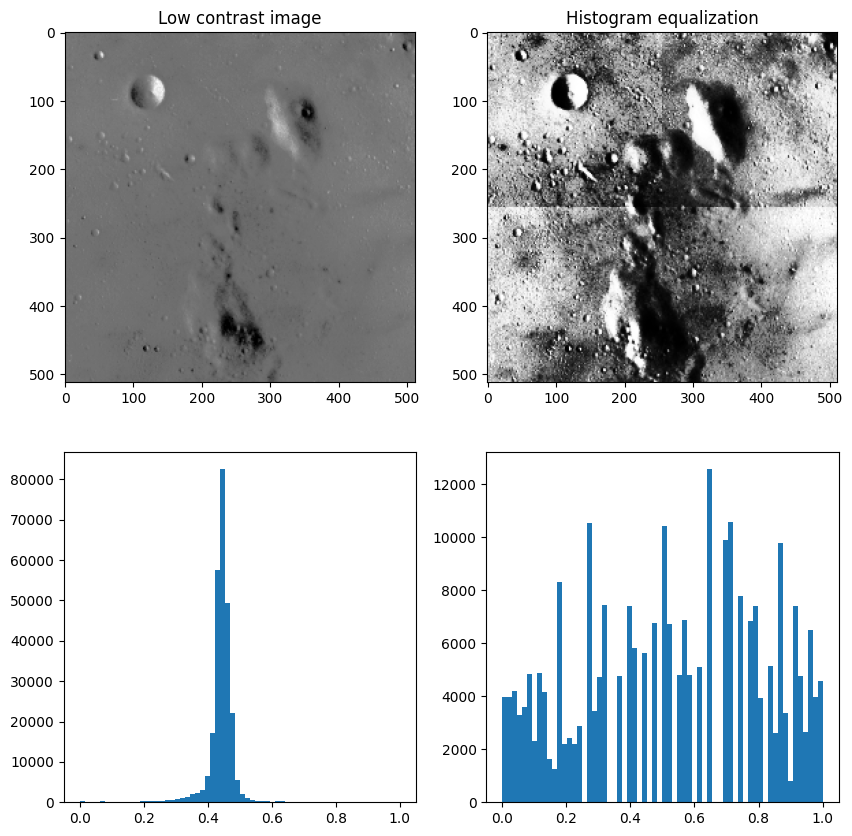

In [23]:
#Check function works for the moon image
img = img_as_float(data.moon())
ch = equalizeQuarters(img)
plotImgAndHist(img, ch, 64)
#Does it look any less unnatural!? What if we had divided further into smaller regions?

#simple sanity check that images are the same size
assert(ch.shape == img.shape)
assert(math.isclose(np.mean(ch), 0.5264107029))
print("All tests passed")

All tests passed


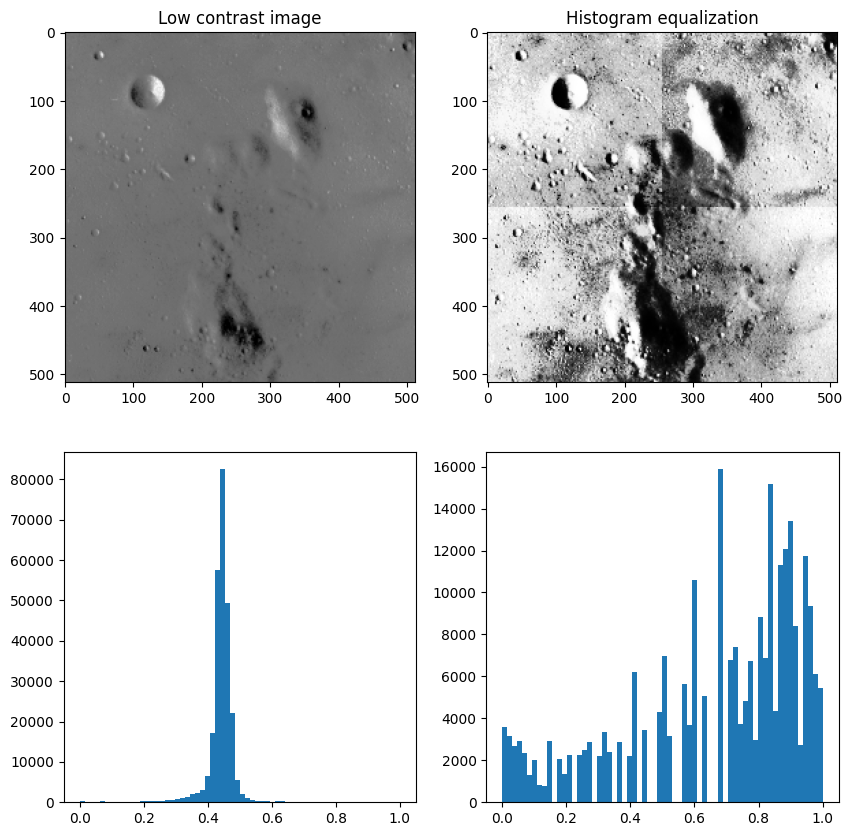

In [24]:
#Check function works for the moon image (this time passing a parameter to equalizeQuarters)
img = img_as_float(data.moon())
ch = equalizeQuarters(img, 32)
plotImgAndHist(img, ch, 64)

assert(math.isclose(np.mean(ch), 0.6626993141))
print("All tests passed")

In [25]:
#Some hidden tests below with a different image and different assert


Some other ways to achieve better looking images are by i) rescaling image to include all intensities that fall within the 2nd and 98th percentiles, and ii) adaptive equalization


In [26]:
# Load an example image
img = data.moon()

# Contrast stretching within specific percentiles
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)


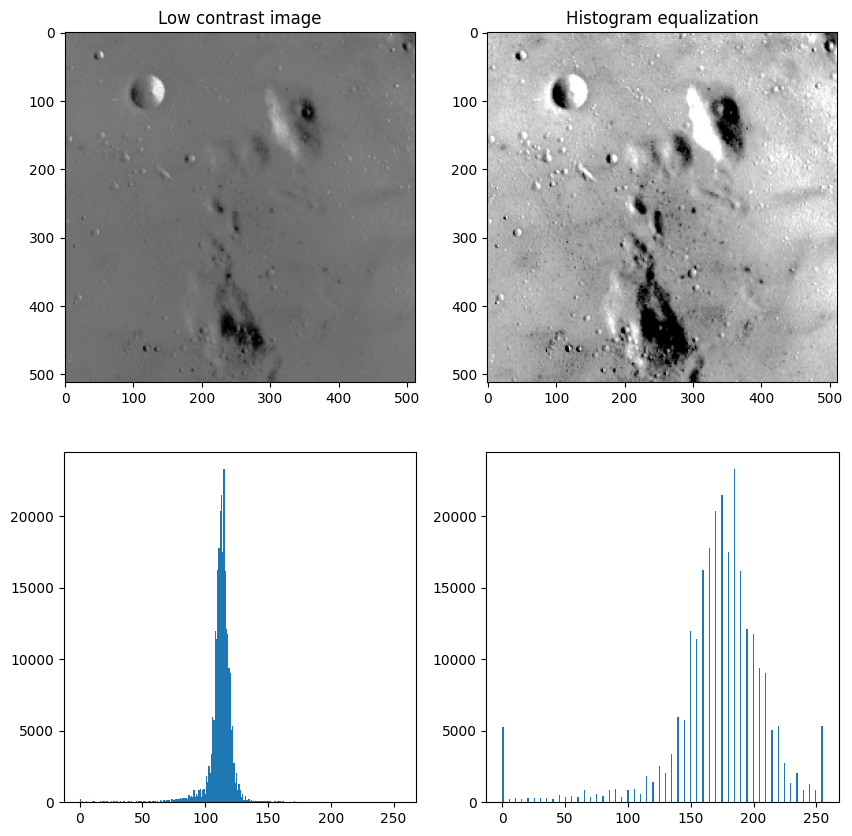

In [27]:
plotImgAndHist(img, img_rescale)

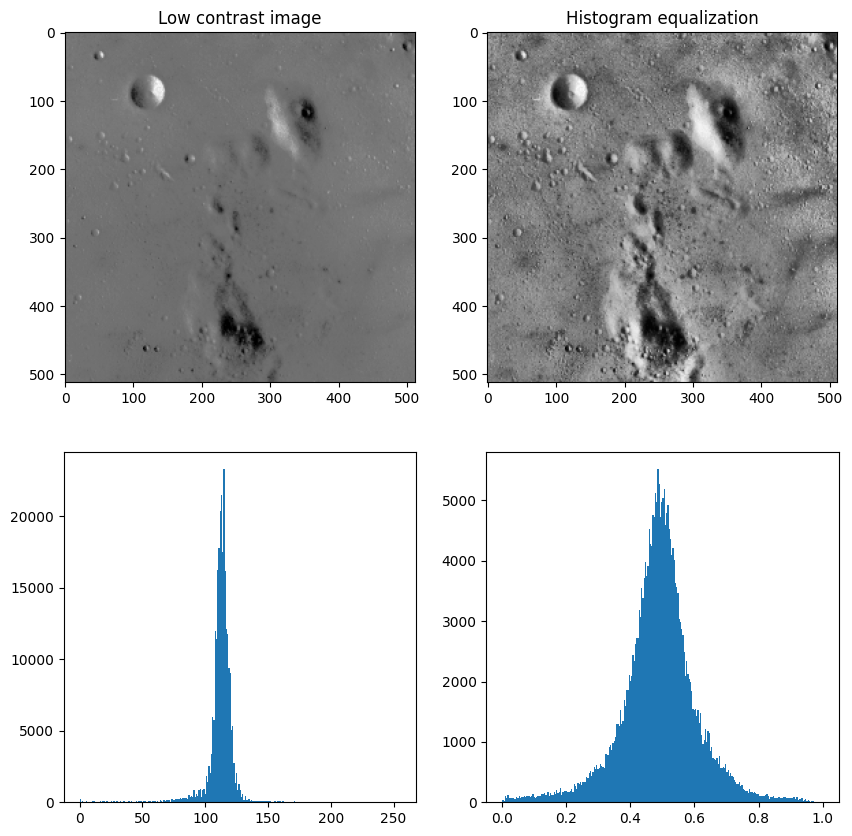

In [28]:
plotImgAndHist(img, img_adapteq)